In [1]:
# Ensure project root is on sys.path so `notebooks` is importable
import sys
from pathlib import Path

def _add_repo_root_to_sys_path() -> None:
    start_dir = Path.cwd()
    repo_root = None
    for candidate in [start_dir, *start_dir.parents]:
        if (candidate / "setup.py").exists() or (candidate / "pyproject.toml").exists() or (candidate / ".git").exists() or (candidate / "requirements.txt").exists():
            repo_root = candidate
            break
    if repo_root is None:
        repo_root = start_dir
    if str(repo_root) not in sys.path:
        sys.path.insert(0, str(repo_root))

_add_repo_root_to_sys_path()

del _add_repo_root_to_sys_path


In [2]:
import re, os
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import curve_fit

data_dir = '../../supplementary_data'


In [3]:
def parse_counts(path: str):
    """Extreu n_yellow i n_blue del nom: .../img_<ny>_<nb>_... ."""
    m = re.search(r'img_(\d+)_(\d+)_', path)
    if m:
        return int(m.group(1)), int(m.group(2))
    return np.nan, np.nan

def parse_equalized(path: str):
    """Marca True si el path conté 'equaliz' (equalized/equalization...)."""
    return "equaliz" in path.lower()

def halberda_p(r, w):
    """Funció psicomètrica del paper (en funció del rati r>=1)."""
    return norm.cdf((r - 1.0) / (w * np.sqrt(1.0 + r**2)))

def fit_weber(group_df, w0=0.25, lower=1e-4, upper=1.0):
    r = group_df["r"].to_numpy(dtype=float)
    y = group_df["p_hat"].to_numpy(dtype=float)
    n = group_df["n_trials"].to_numpy(dtype=float)

    # Desviació estàndard binomial de p̂: sqrt(p(1-p)/n) (clipejada per estabilitat)
    eps = 1e-6
    sigma = np.sqrt(np.clip(y * (1 - y) / n, eps, None))

    # Ajust no lineal ponderat
    popt, pcov = curve_fit(
        halberda_p, r, y,
        p0=[w0], bounds=(lower, upper),
        sigma=sigma, absolute_sigma=True,
        maxfev=20000
    )
    w = float(popt[0])
    # SE i IC95% (aprox.; si estàs a la frontera, millor bootstrap)
    se = float(np.sqrt(pcov[0, 0])) if pcov.size else np.nan
    ci_low = max(lower, w - 1.96 * se) if np.isfinite(se) else np.nan
    ci_high = min(upper, w + 1.96 * se) if np.isfinite(se) else np.nan

    out = {
        "w": w, "w_se": se,
        "w_ci_low": ci_low, "w_ci_high": ci_high,
        "n_bins": group_df["r"].nunique(),
        "n_trials_total": int(group_df["n_trials"].sum())
    }
    return pd.Series(out)

def compute_weber_ratio(data_file_name: str):
    file_path = os.path.join(data_dir, data_file_name)
    df = pd.read_csv(file_path)
    df = df.rename(columns=lambda s: s.strip().lower().replace(" ", "_"))
    df["n_yellow"], df["n_blue"] = zip(*df["image"].map(parse_counts))
    df["equalized"] = df["image"].map(parse_equalized)
    # rati r>=1
    larger = np.maximum(df["n_yellow"], df["n_blue"])
    smaller = np.minimum(df["n_yellow"], df["n_blue"])
    df["r"] = larger / smaller
    df = df[np.isfinite(df["r"]) & (df["r"] > 1)]

    # --- 2) Agregació per rati (cada r és un bin) ---
    values = (
        df.groupby(["equalized", "r"], as_index=False)
        .agg(n_trials=("is_correct", "size"),
            k=("is_correct", "sum"))
    )
    values["p_hat"] = values["k"] / values["n_trials"]

    # Resultats per condició equalized
    res_by_eq = values.groupby("equalized").apply(fit_weber).reset_index()

    # (Opcional) Resultat global col·lapsant equalized
    res_global = fit_weber(values.assign(equalized="ALL").groupby("equalized").get_group("ALL")).to_frame().T
    res_global["equalized"] = "ALL"
    res_global = res_global[["equalized", "w", "w_se", "w_ci_low", "w_ci_high", "n_bins", "n_trials_total"]]

    # Taula final
    return pd.concat([res_by_eq, res_global], ignore_index=True)

In [4]:
biological = compute_weber_ratio("biological_results.csv")
binned = compute_weber_ratio("binned_results.csv")
connection_pruned = compute_weber_ratio("connection_pruned_results.csv")
neuron_binned = compute_weber_ratio("neuron_binned_results.csv")
unconstrained = compute_weber_ratio("unconstrained_results.csv")

In [5]:
# extract "ALL" from all the dataframes and create a new dataframe with the results. add the name of the dataframe as a column
all_results = pd.concat([biological, binned, connection_pruned, neuron_binned, unconstrained], ignore_index=True)
all_results = all_results[all_results["equalized"] == "ALL"]
all_results["dataframe"] = ["biological", "binned", "connection_pruned", "neuron_binned", "unconstrained"]
all_results.drop(columns=["equalized", "n_bins", "n_trials_total"], inplace=True)
all_results


,w,w_se,w_ci_low,w_ci_high,dataframe
2,0.258422,0.003545,0.251474,0.265371,biological
5,0.276477,0.004627,0.267407,0.285546,binned
8,0.208298,0.004517,0.199444,0.217151,connection_pruned
11,0.272163,0.004596,0.263154,0.281172,neuron_binned
14,0.193621,0.004925,0.183967,0.203274,unconstrained


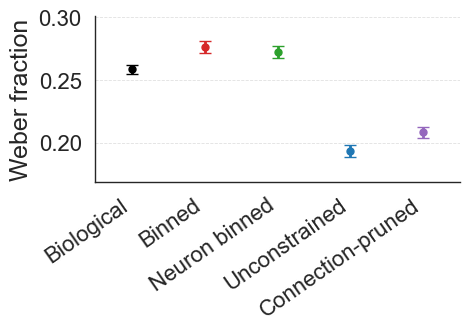

In [11]:
from notebooks.visualization.random_networks_plots.plot_config import PLOT_STYLE_PARAMS, RANDOMIZATION_NAMES, apply_plot_style, get_randomization_colors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# ---- estil (usa el teu diccionari)
rcParams.update(PLOT_STYLE_PARAMS)

# ---- àlies perquè 'binned' agafi el mateix mapping que 'random_binned'
NAME_ALIAS = {
    "biological": "biological",
    "binned": "random_binned",                # <- àlies clau
    "random_binned": "random_binned",
    "neuron_binned": "neuron_binned",
    "unconstrained": "unconstrained",
    "connection_pruned": "connection_pruned",
    "random_pruned": "random_pruned",
}

ORDER = ["Biological", "Binned", "Neuron binned", "Unconstrained", "Connection-pruned"]

def to_label(key: str) -> str:
    k = NAME_ALIAS.get(key, key)
    return RANDOMIZATION_NAMES[k]

def to_color_from_label(label: str) -> str:
    return get_randomization_colors(label)

# ordre i àlies (per mapar "binned" -> "random_binned")
ORDER = ["Biological", "Binned", "Neuron binned", "Unconstrained", "Connection-pruned"]
NAME_ALIAS = {
    "biological": "biological",
    "binned": "random_binned",
    "random_binned": "random_binned",
    "neuron_binned": "neuron_binned",
    "unconstrained": "unconstrained",
    "connection_pruned": "connection_pruned",
}

def plot_weber_by_randomization(all_results: pd.DataFrame, out="weber_by_randomization", dpi=300):
    apply_plot_style()  # usa el teu estil

    df = all_results.copy()
    df["key"] = df["dataframe"].map(lambda k: NAME_ALIAS.get(k, k))
    df["label"] = df["key"].map(RANDOMIZATION_NAMES)
    df["color"] = df["label"].map(get_randomization_colors)

    # manté només els presents i ordena com a la llegenda
    df = df[df["label"].isin(ORDER)]
    df["label"] = pd.Categorical(df["label"], categories=ORDER, ordered=True)
    df = df.sort_values("label")

    x = np.arange(len(df))
    y = df["w"].to_numpy(float)
    yerr = df["w_se"].to_numpy(float)
    colors = df["color"].to_list()
    labels = df["label"].to_list()

    fig, ax = plt.subplots(figsize=(4.6, 3.2))

    for i, (yi, sei, ci) in enumerate(zip(y, yerr, colors)):
        ax.errorbar(i, yi, yerr=sei, fmt="o", color=ci, capsize=4, elinewidth=2)

    # eix X compacte, sense tallar punts
    ax.set_xlim(-0.5, len(x) - 0.5)
    ax.set_xticks(x, labels, rotation=35, ha="right")

    # eix Y compacte (amb marge per a les barres d’error)
    pad = 5 * (np.nanmax(yerr) if len(yerr) else 0.0)
    ax.set_ylim(y.min() - pad, y.max() + pad)

    ax.set_ylabel("Weber fraction")
    ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig.tight_layout(pad=0.2)

    out = "weber_by_randomization"
    plots_dir = os.path.join("../..", "plots")
    os.makedirs(plots_dir, exist_ok=True)
    fig.savefig(os.path.join(plots_dir, f"{out}.png"), dpi=300, bbox_inches="tight")
    fig.savefig(os.path.join(plots_dir, f"{out}.pdf"), dpi=300, bbox_inches="tight")
    
    return fig, ax

# --- crida
fig, ax = plot_weber_by_randomization(all_results)

In [36]:
!pip install seaborn

'pip' is not recognized as an internal or external command,
operable program or batch file.
